<a href="https://colab.research.google.com/github/ShannieChacham/Workout_Exercises_Video_Classifier/blob/main/Copy_of_Shannie_Chacham_0_92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
import json
import time
from pathlib import Path
from datetime import datetime
from collections import defaultdict
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
from IPython.display import display

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models.video import r3d_18, R3D_18_Weights
from torchvision import transforms
import torch.nn.functional as F

from glob import glob
from typing import List, Tuple
from tqdm import tqdm
from collections import defaultdict, Counter


In [2]:
from google.colab import drive
drive.mount('/content/drive')


zip_path = "/content/drive/MyDrive/Beilinson/dataset.zip"

extract_path = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

output_path = "/content/drive/MyDrive/Beilinson/figs"
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
!nvidia-smi


# **Exploratory Data Analysis**


In [ ]:
def video_duration_sec(video_path: Path) -> float:
    try:
        cap = cv2.VideoCapture(str(video_path))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        cap.release()
        return round(frames / fps, 2) if fps else 0.0
    except Exception as e:
        print(f"[ERROR] {video_path}: {e}")
        return 0.0

def seconds_to_mmss(seconds: float) -> str:
    m, s = divmod(int(seconds), 60)
    return f"{m}:{s:02d}"

# def mmss_to_seconds(t: str) -> int:
#     m, s = map(int, t.split(":"))
#     return m * 60 + s

def gather_video_metadata(root_dir: str) -> pd.DataFrame:
    video_exts = {'.mp4', '.avi', '.mov', '.mkv', '.wmv'}
    records = []

    for video_file in Path(root_dir).rglob("*"):
        if video_file.suffix.lower() in video_exts:
            try:
                category = video_file.parent.name
                size_mb = round(video_file.stat().st_size / (1024 ** 2), 2)
                modified = datetime.fromtimestamp(video_file.stat().st_mtime).strftime('%Y-%m-%d %H:%M')
                duration = video_duration_sec(video_file)
                records.append({
                    'Category': category,
                    'Filename': video_file.name,
                    'Format': video_file.suffix[1:],
                    'Size_MB': size_mb,
                    'Duration_sec': duration,
                    'Modified': modified
                    # 'filepath': str(video_file)
                })
            except Exception as e:
                print(f"[ERROR] Failed to process {video_file}: {e}")

    return pd.DataFrame(records)

def summarize_videos(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame()

    summary = (
        df.groupby('Category')
          .agg(
              Total_Videos=('Filename', 'count'),
              Formats=('Format', lambda x: ', '.join(f"{f}: {x.tolist().count(f)}" for f in set(x))),
              Total_Size_MB=('Size_MB', 'sum'),
              Size_Std_MB=('Size_MB', lambda x: round(x.std(), 2) if len(x) > 1 else 0),
              Total_Duration=('Duration_sec', 'sum'),
              Duration_Std=('Duration_sec', lambda x: x.std() if len(x) > 1 else 0)
          )
          .reset_index()
    )

    summary['Total_Duration'] = summary['Total_Duration'].apply(seconds_to_mmss)
    summary['Duration_Std'] = summary['Duration_Std'].apply(seconds_to_mmss)

    # Add overall total row
    total_row = {
        'Category': 'All',
        'Total_Videos': df.shape[0],
        'Formats': 'All',
        'Total_Size_MB': round(df['Size_MB'].sum(), 2),
        'Size_Std_MB': round(df['Size_MB'].std(), 2) if len(df) > 1 else 0,
        'Total_Duration': seconds_to_mmss(df['Duration_sec'].sum()),
        'Duration_Std': seconds_to_mmss(df['Duration_sec'].std() if len(df) > 1 else 0)
    }
    summary = pd.concat([summary, pd.DataFrame([total_row])], ignore_index=True)

    return summary


def analyze_video_data(df: pd.DataFrame, summary_df: pd.DataFrame, output_dir: str = "./figs"):
    os.makedirs(output_dir, exist_ok=True)

    print("Summary Overview:")
    display(summary_df)
    print("\nVideo Details:")
    display(df.head())

    fig_size = (12, 6)

    # Bar plot: number of videos per category
    plt.figure(figsize=fig_size)
    video_counts = df['Category'].value_counts()
    bars = plt.bar(video_counts.index, video_counts.values, color='skyblue')
    plt.title("Number of Videos by Category")
    plt.xlabel("Exercise Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 f"{int(bar.get_height())}", ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/video_count_per_category.png")
    plt.show()

    # Boxplot: duration by category
    plt.figure(figsize=fig_size)
    sns.boxplot(data=df, x='Category', y='Duration_sec', palette='pastel')
    plt.title("Video Duration by Category")
    plt.xlabel("Exercise")
    plt.ylabel("Seconds")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/duration_by_category.png")
    plt.show()

    # Boxplot: duration by category without outliers
    no_outliers_df = df[~df['Category'].isin(['plank', 'romanian deadlift'])]

    plt.figure(figsize=fig_size)
    sns.boxplot(data=no_outliers_df, x='Category', y='Duration_sec', palette='pastel')
    plt.title("Video Duration by Category Without Outliers")
    plt.xlabel("Exercise")
    plt.ylabel("Seconds")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/duration_by_category_without_outliers.png")
    plt.show()

    # Boxplot: duration by category for short clips only
    short_df = df[df['Duration_sec'] < 60]
    if not short_df.empty:
        plt.figure(figsize=fig_size)
        sns.boxplot(data=short_df, x='Category', y='Duration_sec', palette='Set2')
        plt.title("Short Videos (<60s) by Category")
        plt.xlabel("Exercise")
        plt.ylabel("Seconds")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"{output_dir}/short_videos_boxplot.png")
        plt.show()

    # Boxplot: video file size by category
    plt.figure(figsize=fig_size)
    sns.boxplot(data=df, x='Category', y='Size_MB', palette='Set3')
    plt.title("Video File Size by Category")
    plt.xlabel("Exercise")
    plt.ylabel("Size (MB)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/size_by_category.png")
    plt.show()

In [ ]:
video_df = gather_video_metadata(extract_path)
summary_df = summarize_videos(video_df)


Summary Overview:


,Category,Total_Videos,Formats,Total_Size_MB,Size_Std_MB,Total_Duration,Duration_Std
0,barbell biceps curl,62,mp4: 62,82.84,1.67,3:58,0:02
1,bench press,61,mp4: 61,110.92,2.97,3:49,0:04
2,chest fly machine,28,mp4: 28,55.33,4.24,2:55,0:05
3,deadlift,32,mp4: 32,65.31,4.53,3:07,0:06
4,decline bench press,12,"MOV: 6, mp4: 6",427.35,36.18,2:58,0:08
5,hammer curl,19,"MOV: 7, mp4: 12",364.64,19.80,3:05,0:05
6,hip thrust,18,"MOV: 4, mp4: 14",251.24,15.29,3:33,0:09
7,incline bench press,33,mp4: 33,140.33,8.19,4:25,0:11
8,lat pulldown,51,mp4: 51,107.20,2.22,3:41,0:02
9,lateral raise,37,"MOV: 6, mp4: 31",422.71,16.90,5:07,0:04



Video Details:


,Category,Filename,Format,Size_MB,Duration_sec,Modified
0,barbell biceps curl,barbell biceps curl_49.mp4,mp4,1.15,3.00,2025-07-24 19:58
1,barbell biceps curl,barbell biceps curl_53.mp4,mp4,3.58,5.87,2025-07-24 19:58
2,barbell biceps curl,barbell biceps curl_54.mp4,mp4,2.56,4.40,2025-07-24 19:58
3,barbell biceps curl,barbell biceps curl_37.mp4,mp4,0.24,1.97,2025-07-24 19:58
4,barbell biceps curl,barbell biceps curl_32.mp4,mp4,0.27,2.17,2025-07-24 19:58


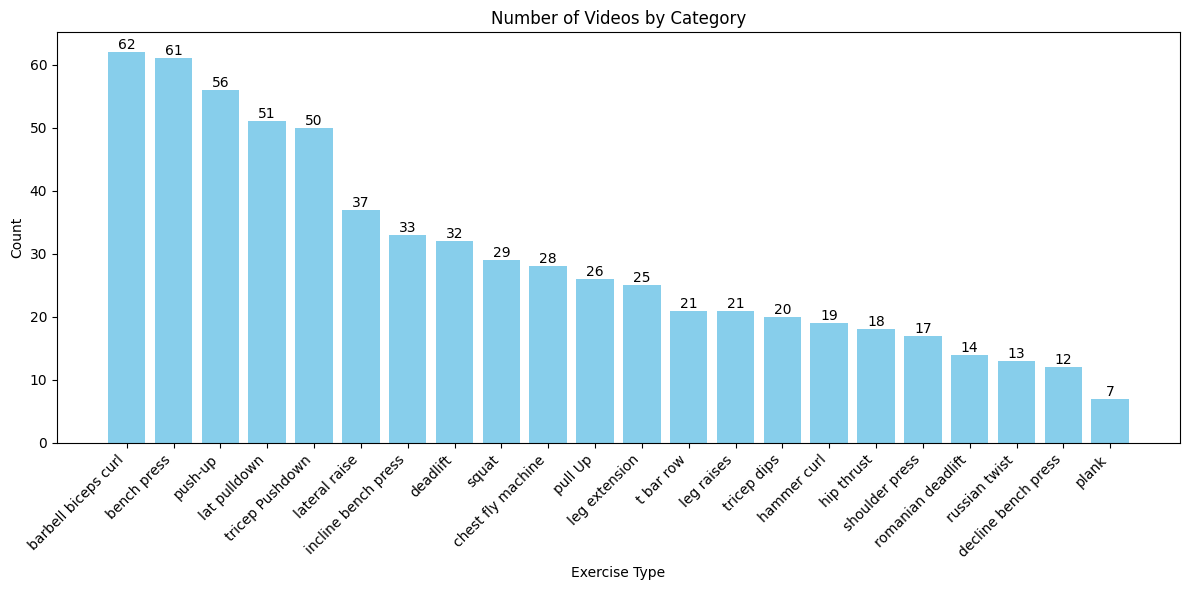

/tmp/ipython-input-3-53145672.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Duration_sec', palette='pastel')


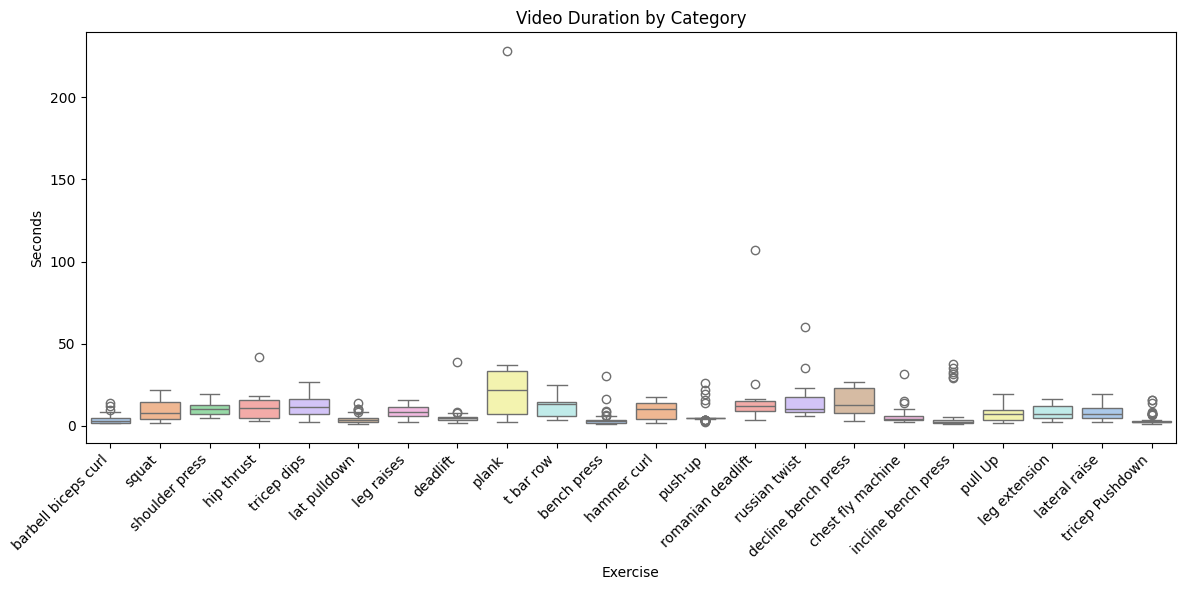

/tmp/ipython-input-3-53145672.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=no_outliers_df, x='Category', y='Duration_sec', palette='pastel')


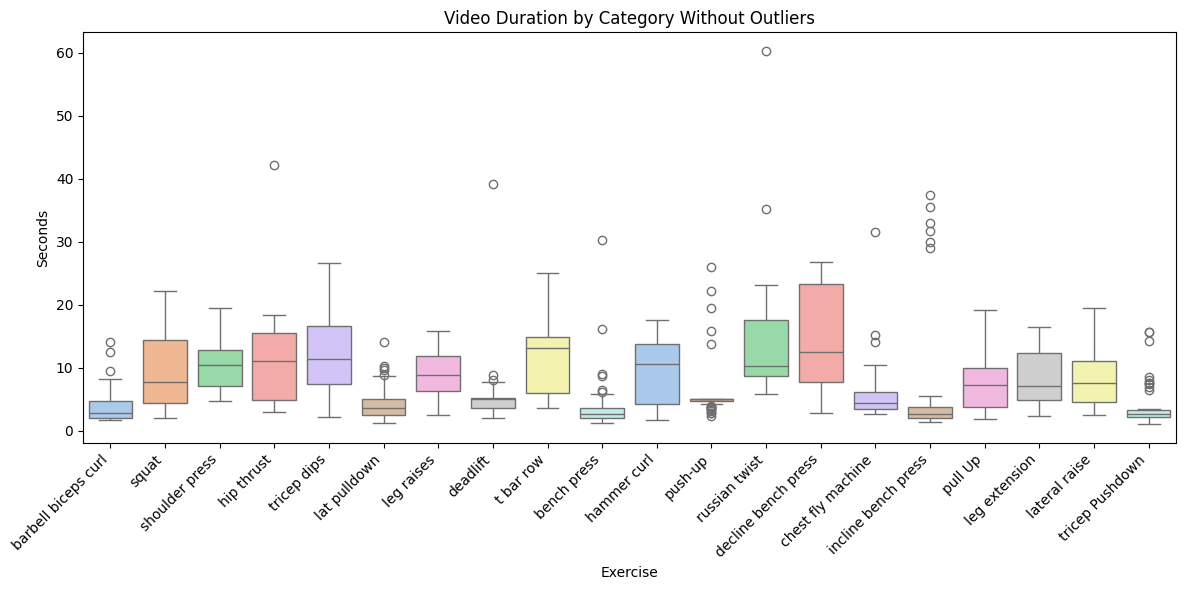

/tmp/ipython-input-3-53145672.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=short_df, x='Category', y='Duration_sec', palette='Set2')


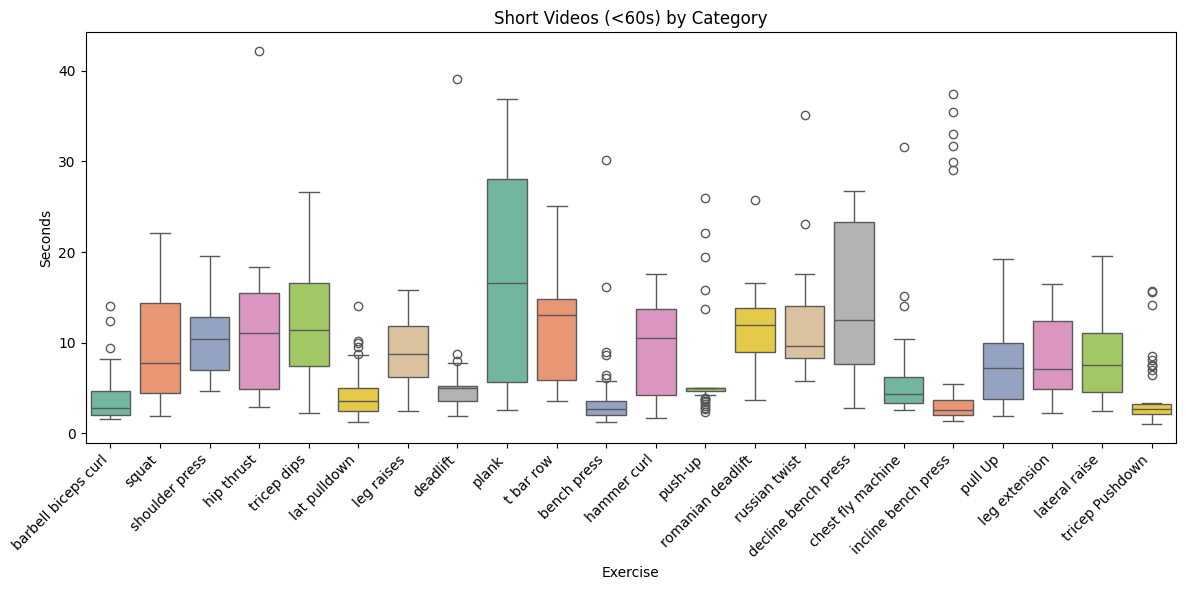

/tmp/ipython-input-3-53145672.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Size_MB', palette='Set3')


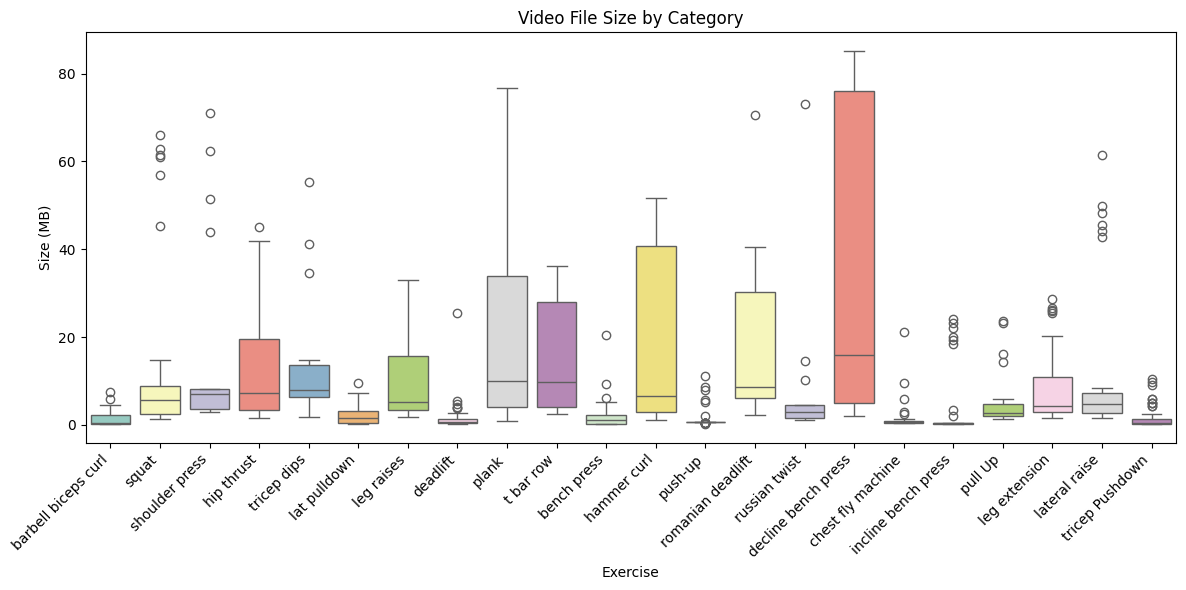

In [ ]:
analyze_video_data(video_df, summary_df, output_dir=output_path)

# **Data Preprocess**

### **Built Dataset**

In [3]:
def build_dataframe_from_folder(root_dir: str, extensions=('.mp4', '.avi', '.mov')) -> Tuple[pd.DataFrame, dict]:
    data = []
    label_map = {}
    for i, class_folder in enumerate(sorted(os.listdir(root_dir))):
        class_path = os.path.join(root_dir, class_folder)
        if not os.path.isdir(class_path):
            continue
        label_map[class_folder] = i
        for fname in glob(os.path.join(class_path, '*')):
            if fname.lower().endswith(extensions):
                data.append({
                    'filepath': fname,
                    'label': i,
                    'category': class_folder
                })
    return pd.DataFrame(data), label_map


In [4]:
df, label_map = build_dataframe_from_folder(extract_path)
df.head()


,filepath,label,category
0,/content/dataset/barbell biceps curl/barbell b...,0,barbell biceps curl
1,/content/dataset/barbell biceps curl/barbell b...,0,barbell biceps curl
2,/content/dataset/barbell biceps curl/barbell b...,0,barbell biceps curl
3,/content/dataset/barbell biceps curl/barbell b...,0,barbell biceps curl
4,/content/dataset/barbell biceps curl/barbell b...,0,barbell biceps curl


In [5]:
label_map

{'barbell biceps curl': 0,
 'bench press': 1,
 'chest fly machine': 2,
 'deadlift': 3,
 'decline bench press': 4,
 'hammer curl': 5,
 'hip thrust': 6,
 'incline bench press': 7,
 'lat pulldown': 8,
 'lateral raise': 9,
 'leg extension': 10,
 'leg raises': 11,
 'plank': 12,
 'pull Up': 13,
 'push-up': 14,
 'romanian deadlift': 15,
 'russian twist': 16,
 'shoulder press': 17,
 'squat': 18,
 't bar row': 19,
 'tricep Pushdown': 20,
 'tricep dips': 21}

### **Data Split**

In [6]:
def prepare_split_dataframe(df: pd.DataFrame, output_dir: str, test_size=0.15, val_size=0.15, seed=42):
    train_df, temp_df = train_test_split(df, test_size=(test_size + val_size), stratify=df['label'], random_state=seed)
    relative_val_size = val_size / (test_size + val_size)
    val_df, test_df = train_test_split(temp_df, test_size=1 - relative_val_size, stratify=temp_df['label'], random_state=seed)

    # Save as CSVs
    os.makedirs(output_dir, exist_ok=True)
    train_df.to_csv(f"{output_dir}/train.csv", index=False)
    val_df.to_csv(f"{output_dir}/val.csv", index=False)
    test_df.to_csv(f"{output_dir}/test.csv", index=False)

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [7]:
splits_dir = "/content/drive/MyDrive/Beilinson/splits"

train_df, val_df, test_df = prepare_split_dataframe(df, output_dir=splits_dir)


In [8]:
train_df

,filepath,label,category
0,/content/dataset/bench press/bench press_46.mp4,1,bench press
1,/content/dataset/t bar row/t bar row_8.mp4,19,t bar row
2,/content/dataset/tricep dips/tricep dips_19.mp4,21,tricep dips
3,/content/dataset/deadlift/deadlift_20.mp4,3,deadlift
4,/content/dataset/bench press/bench press_48.mp4,1,bench press
...,...,...,...
451,/content/dataset/incline bench press/incline b...,7,incline bench press
452,/content/dataset/hammer curl/hammer curl_12.mp4,5,hammer curl
453,/content/dataset/incline bench press/incline b...,7,incline bench press
454,/content/dataset/barbell biceps curl/barbell b...,0,barbell biceps curl


In [9]:
# Count per category for each split
train_counts = train_df['label'].value_counts().rename('Train')
val_counts = val_df['label'].value_counts().rename('Validation')
test_counts = test_df['label'].value_counts().rename('Test')

# Combine into single DataFrame
split_summary = pd.concat([train_counts, val_counts, test_counts], axis=1).fillna(0).astype(int)

# Display the summary
display(split_summary)


,Train,Validation,Test
label,,,
1,43,9,9
0,43,10,9
14,39,8,9
8,36,7,8
20,35,8,7
9,26,6,5
7,23,5,5
3,22,5,5
18,20,4,5


### **Video Dataset Construction**

The `VideoClipDataset` class loads multiple short clips from raw video files for training 3D CNN models.
Each clip is treated as a separate training sample. Specifically, the dataset:

* Extracts up to N clips of T consecutive frames (e.g., 16) from each video, evenly spaced across the video's duration

* Automatically backtracks to earlier frames if a full-length clip cannot be extracted from the end

* Supports short videos by looping the beginning frames to fill the clip if necessary

* Applies resizing, normalization, and format conversion to each frame

* Stacks the frames into a tensor of shape (3, T, 112, 112)

* Returns each clip along with its corresponding label

This design enables efficient and consistent on-the-fly loading of video segments, ensuring full usage of each video regardless of length or resolution, without needing to preprocess the entire dataset.



In [10]:
## Check if there is a video with less then 16 frames
def get_fps_and_num_frames(filepath):
    cap = cv2.VideoCapture(filepath)
    if not cap.isOpened():
        print(f"Failed to open {filepath}")
        return None, None
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration_sec = cap.get(cv2.CAP_PROP_FRAME_COUNT) / fps if fps > 0 else 0
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return fps, num_frames

fps_list = []
num_frames_list = []

for filepath in df["filepath"]:
    path = os.path.join(extract_path, filepath)
    fps, num_frames = get_fps_and_num_frames(path)
    fps_list.append(fps)
    num_frames_list.append(num_frames)

df["FPS"] = fps_list
df["Num_Frames"] = num_frames_list

short_videos = df[df["Num_Frames"] < 16]
print("Videos with fewer than 16 frames:")
print(short_videos)

Videos with fewer than 16 frames:
Empty DataFrame
Columns: [filepath, label, category, FPS, Num_Frames]
Index: []


In [11]:
class VideoClipDataset(Dataset):
    """
    A PyTorch Dataset that extracts multiple temporal clips from each video.
    Each clip has a fixed number of frames (clip_len), and every clip is returned as an independent sample.

    Parameters:
    - df (pd.DataFrame): Must include 'filepath' and 'label' columns.
    - clip_len (int): Number of frames per clip.
    - num_clips_per_video (int): How many clips to sample from each video (evenly spaced).
    - resize (tuple): (H, W) target size for each frame.
    - allow_short (bool): Whether to include videos shorter than clip_len by looping frames.
    """

    def __init__(self, df, clip_len=16, num_clips_per_video=1, resize=(128, 171), allow_short=True):
        """
        Initialize the dataset and prepare the (video_path, label, start_frame) samples list.
        """
        self.clip_len = clip_len
        self.resize = resize
        self.allow_short = allow_short
        self.samples = []  # list of tuples: (filepath, label, clip_start_index)

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.resize),
            transforms.CenterCrop((112, 112)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
            transforms.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])
        ])

        for _, row in df.iterrows():
            path = row['filepath']
            label = row['label']

            cap = cv2.VideoCapture(path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.release()

            if total_frames < self.clip_len:
                if not allow_short:
                    continue
                else:
                    # Include one clip starting at frame 0 with looping logic
                    self.samples.append((path, label, 0))
                    continue

            # Divide video into consecutive clips of clip_len frames
            # Each clip starts at: 0, clip_len, 2*clip_len, etc.
            total_possible_clips = total_frames // self.clip_len
            remaining_frames = total_frames % self.clip_len

            # if total_possible_clips == 0:
            #     # If not even one full clip is available, treat as short video
            #     if allow_short:
            #         self.samples.append((path, label, 0))
            #     continue

            # If there are remaining frames, add an additional clip starting from the end backwards
            clip_starts = []

            # Add regular clips (non-overlapping)
            for i in range(total_possible_clips):
                clip_starts.append(i * self.clip_len)

            # If there are remaining frames, add a clip from the end
            if remaining_frames > 0:
                last_clip_start = total_frames - self.clip_len
                # Ensure the last clip is not identical to the previous clip
                if not clip_starts or last_clip_start != clip_starts[-1]:
                    clip_starts.append(last_clip_start)

            total_available_clips = len(clip_starts)

            # Select the N middle clips
            clips_to_take = min(num_clips_per_video, total_available_clips)

            if clips_to_take == total_available_clips:
                # Take all available clips
                selected_starts = clip_starts
            else:
                # Take the middle clips
                start_skip = (total_available_clips - clips_to_take) // 2
                selected_starts = clip_starts[start_skip:start_skip + clips_to_take]

            # Add the selected clips
            for start_frame in selected_starts:
                self.samples.append((path, label, start_frame))

    def __len__(self):
        """
        Return total number of clips across all videos.
        """
        return len(self.samples)

    def _load_clip(self, path, start_idx):
        """
        Load a clip of self.clip_len frames starting at start_idx from a video.

        Inputs:
        - path (str): path to the video file
        - start_idx (int): starting frame index

        Output:
        - clip (torch.Tensor): Tensor of shape [3, T, H, W]
        """
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Adjust if not enough frames remain
        if total_frames - start_idx < self.clip_len:
            start_idx = max(0, total_frames - self.clip_len)

        cap.set(cv2.CAP_PROP_POS_FRAMES, start_idx)
        frames = []

        for _ in range(self.clip_len):
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = self.transform(frame)
            frames.append(frame)

        cap.release()

        # Loop over beginning if clip is too short
        while len(frames) < self.clip_len:
            needed = self.clip_len - len(frames)
            loop_frames = frames[:needed]
            frames.extend(loop_frames)
        if len(frames) == 0:
          raise ValueError(f"[ERROR] No frames read from video: {path} starting at frame {start_idx}")

        return torch.stack(frames, dim=1)  # [C, T, H, W]

    def __getitem__(self, idx):
        """
        Retrieve a single clip and its label.

        Input:
        - idx (int): index of the clip sample

        Output:
        - clip (Tensor): shape [3, clip_len, H, W]
        - label (int): class label
        - path (str): path to the video file
        """
        path, label, start_idx = self.samples[idx]
        clip = self._load_clip(path, start_idx)
        return clip, label, path


    def __repr__(self):
        """
        Return a string summary when printing the dataset object.
        """
        total_videos = len(set([path for path, _, _ in self.samples]))
        return (
            f"VideoClipDataset\n"
            f"{'-'*25}\n"
            f"Total video files: {total_videos}\n"
            f"Total clips: {len(self)}\n"
            f"Clip length: {self.clip_len} frames\n"
            f"Target size: {self.resize[0]}x{self.resize[1]} + CenterCrop to 112x112\n"
            f"Short videos allowed: {self.allow_short}\n"
            f"Clips per video: approx. {len(self.samples)//total_videos if total_videos > 0 else 0}"
        )

    def summary(self, label_names: dict = None):
        """
        Print number of clips per label.

        Parameters:
        - label_names (dict): Optional mapping from label index to category name
        """
        clip_counts = Counter([label for _, label, _ in self.samples])
        print("Clips per label:")
        for label, count in sorted(clip_counts.items()):
            name = label_names[label] if label_names else str(label)
            print(f"  {name:20s}: {count} clips")

#### Train

In [12]:
train_dataset = VideoClipDataset(train_df, clip_len=16, num_clips_per_video=6, allow_short=True)
print("Samples in dataset:", len(train_dataset))

Samples in dataset: 2564


In [13]:
train_dataset

VideoClipDataset
-------------------------
Total video files: 456
Total clips: 2564
Clip length: 16 frames
Target size: 128x171 + CenterCrop to 112x112
Short videos allowed: True
Clips per video: approx. 5

In [14]:
inv_map = {v: k for k, v in label_map.items()}

train_dataset.summary(label_names=inv_map)

Clips per label:
  barbell biceps curl : 220 clips
  bench press         : 213 clips
  chest fly machine   : 118 clips
  deadlift            : 126 clips
  decline bench press : 47 clips
  hammer curl         : 76 clips
  hip thrust          : 77 clips
  incline bench press : 114 clips
  lat pulldown        : 203 clips
  lateral raise       : 154 clips
  leg extension       : 102 clips
  leg raises          : 88 clips
  plank               : 29 clips
  pull Up             : 103 clips
  push-up             : 233 clips
  romanian deadlift   : 60 clips
  russian twist       : 54 clips
  shoulder press      : 72 clips
  squat               : 118 clips
  t bar row           : 90 clips
  tricep Pushdown     : 185 clips
  tricep dips         : 82 clips


#### Validation

In [15]:
val_dataset = VideoClipDataset(val_df, clip_len=16, num_clips_per_video=6, allow_short=True)
print("Samples in dataset:", len(val_dataset))

Samples in dataset: 548


In [16]:
val_dataset

VideoClipDataset
-------------------------
Total video files: 98
Total clips: 548
Clip length: 16 frames
Target size: 128x171 + CenterCrop to 112x112
Short videos allowed: True
Clips per video: approx. 5

In [17]:
val_dataset.summary(label_names=inv_map)

Clips per label:
  barbell biceps curl : 53 clips
  bench press         : 43 clips
  chest fly machine   : 24 clips
  deadlift            : 30 clips
  decline bench press : 12 clips
  hammer curl         : 18 clips
  hip thrust          : 12 clips
  incline bench press : 26 clips
  lat pulldown        : 37 clips
  lateral raise       : 36 clips
  leg extension       : 23 clips
  leg raises          : 18 clips
  plank               : 6 clips
  pull Up             : 24 clips
  push-up             : 48 clips
  romanian deadlift   : 12 clips
  russian twist       : 12 clips
  shoulder press      : 18 clips
  squat               : 21 clips
  t bar row           : 18 clips
  tricep Pushdown     : 39 clips
  tricep dips         : 18 clips


# **Model Architecture**

## **3D CNN**

### **Build model function**

In [ ]:
# def build_3d_cnn_model(num_classes: int) -> nn.Module:
#     """
#     Build a 3D ResNet-18 model for video classification with pretrained weights.

#     Args:
#         num_classes (int): number of target classes

#     Returns:
#         nn.Module: a pretrained r3d_18 model with a modified classification head
#     """
#     # Load pretrained weights from Kinetics-400
#     weights = R3D_18_Weights.DEFAULT
#     model = r3d_18(weights=weights)

#     # Replace final classification layer
#     model.fc = nn.Linear(model.fc.in_features, num_classes)

#     return model

In [18]:
model = r3d_18(weights=R3D_18_Weights.DEFAULT)

for name, module in model.named_children():
    print(name)

print(f"layer4")
for name, param in model.layer4.named_parameters():
    print(name)


Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 231MB/s]


stem
layer1
layer2
layer3
layer4
avgpool
fc
layer4
0.conv1.0.weight
0.conv1.1.weight
0.conv1.1.bias
0.conv2.0.weight
0.conv2.1.weight
0.conv2.1.bias
0.downsample.0.weight
0.downsample.1.weight
0.downsample.1.bias
1.conv1.0.weight
1.conv1.1.weight
1.conv1.1.bias
1.conv2.0.weight
1.conv2.1.weight
1.conv2.1.bias


In [19]:
''' Advenced '''

def build_3d_cnn_model(num_classes: int, freeze_backbone: bool = True) -> nn.Module:
    """
    Build a 3D ResNet-18 model with a custom MLP classification head.

    Args:
        num_classes (int): number of target classes
        freeze_backbone (bool): if True, freeze all layers except the classification head

    Returns:
        nn.Module: modified r3d_18 model
    """
    weights = R3D_18_Weights.DEFAULT
    model = r3d_18(weights=weights)

    in_features = model.fc.in_features

    model.fc = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(256, num_classes)
    )

  # model.fc = nn.Sequential(
  #     nn.Linear(in_features, 512),
  #     nn.ReLU(),
  #     nn.Dropout(0.5),
  #     nn.Linear(512, 256),
  #     nn.ReLU(),
  #     nn.Linear(256, num_classes)
  # )

    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
        for param in model.layer4.parameters():
            param.requires_grad = True

    return model


### **Loss Criterion**

In [26]:
class_weights = torch.ones(22)
for i in [3, 6, 4, 7, 12, 19, 15]:
    class_weights[i] = 2.0
class_weights = class_weights.to(device)
class_weights

tensor([1., 1., 1., 2., 2., 1., 2., 2., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1.,
        1., 2., 1., 1.], device='cuda:0')

In [27]:
for i, w in enumerate(class_weights.tolist()):
    label_name = inv_map[i]
    print(f"{label_name:<25} | class {i:2} | weight: {w:.4f}")

barbell biceps curl       | class  0 | weight: 1.0000
bench press               | class  1 | weight: 1.0000
chest fly machine         | class  2 | weight: 1.0000
deadlift                  | class  3 | weight: 2.0000
decline bench press       | class  4 | weight: 2.0000
hammer curl               | class  5 | weight: 1.0000
hip thrust                | class  6 | weight: 2.0000
incline bench press       | class  7 | weight: 2.0000
lat pulldown              | class  8 | weight: 1.0000
lateral raise             | class  9 | weight: 1.0000
leg extension             | class 10 | weight: 1.0000
leg raises                | class 11 | weight: 1.0000
plank                     | class 12 | weight: 2.0000
pull Up                   | class 13 | weight: 1.0000
push-up                   | class 14 | weight: 1.0000
romanian deadlift         | class 15 | weight: 2.0000
russian twist             | class 16 | weight: 1.0000
shoulder press            | class 17 | weight: 1.0000
squat                     | 

### **Training loop**

In [28]:
def train_model(model, train_loader, val_loader, val_dataset, device, weights=None, num_epochs=10, lr=1e-3, save_dir=None):
    """
    Train a 3D CNN model on clips, and evaluate by majority vote per video.

    Args:
        model (nn.Module): the model to train
        train_loader (DataLoader): training data loader (per-clip)
        val_loader (DataLoader): validation loader (per-clip, includes filepath)
        val_dataset (VideoClipDataset): validation dataset object (needed for aggregation methods)
        device (torch.device): CUDA or CPU
        num_epochs (int): number of training epochs
        lr (float): learning rate
        save_dir (str): directory to save model checkpoints and training history

    Returns:
        model: the trained model
        history: dict with training and validation metrics per epoch
    """
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    model = model.to(device)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss(weight=weights)

    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr
    )


    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_video_acc': [],
        'val_video_loss': []
    }

    for epoch in range(num_epochs):
        # === TRAINING ===
        model.train()
        total, correct, running_loss = 0, 0, 0.0
        train_bar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training")

        for clips, labels, _ in train_bar:
            clips, labels = clips.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(clips)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            train_bar.set_postfix(loss=loss.item(), acc=correct/total)

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)

        # === VALIDATION ===
        model.eval()
        val_predictions_by_path = defaultdict(list)
        criterion_val = nn.CrossEntropyLoss()
        true_labels_by_path = {}

        val_total, val_correct, val_running_loss = 0, 0, 0.0

        val_bar = tqdm(val_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Validation")
        with torch.no_grad():
            for clips, labels, paths in val_bar:
                clips = clips.to(device)
                labels = labels.to(device)
                outputs = model(clips)
                loss = criterion_val(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                val_bar.set_postfix(loss=loss.item(), acc=val_correct / val_total)

                # Group predictions by video path
                for path, pred, label in zip(paths, outputs, labels):
                    val_predictions_by_path[path].append(pred.cpu())
                    true_labels_by_path[path] = label.cpu().item()

        val_acc = val_correct / val_total
        val_loss = val_running_loss / len(val_loader)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)


        # Video-level evaluation using softmax averaging
        video_level_results = []
        correct_videos = 0
        total_video_loss = 0.0

        for path, pred_list in val_predictions_by_path.items():
            preds_stack = torch.stack(pred_list)
            avg_preds = preds_stack.mean(dim=0)
            avg_probs = F.softmax(avg_preds, dim=0)
            predicted_label = torch.argmax(avg_probs).item()
            true_label = true_labels_by_path[path]
            confidence = avg_probs[predicted_label].item()
            target_tensor = torch.tensor([true_label], dtype=torch.long, device=avg_preds.device)
            loss_video = criterion_val(avg_preds.unsqueeze(0), target_tensor)
            total_video_loss += loss_video.item()

            video_level_results.append({
                'video_path': path,
                'true_label': true_label,
                'predicted_label': predicted_label,
                'confidence': confidence
            })

            if predicted_label == true_label:
                correct_videos += 1

        video_level_acc = correct_videos / len(video_level_results)
        video_level_loss = total_video_loss / len(video_level_results)
        print(f"video_level_acc {video_level_acc}")
        print(f"video_level_loss {video_level_loss}")

        history['val_video_acc'].append(video_level_acc)
        history['val_video_loss'].append(video_level_loss)

        if save_dir:
            csv_path = os.path.join(save_dir, f"video_level_predictions_epoch{epoch+1}.csv")
            pd.DataFrame(video_level_results).to_csv(csv_path, index=False)

        # === Save Model Per Epoch===
        if save_dir:
            model_path = os.path.join(save_dir, f"3dcnn_epoch{epoch+1}.pt")
            torch.save(model.state_dict(), model_path)

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save history as JSON
    if save_dir:
        history_path = os.path.join(save_dir, "training_history.json")
        with open(history_path, 'w') as f:
            json.dump(history, f)

    return model, history


### **Running & Evaluation**

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_df['label'].unique())
print(f"num_classes = {num_classes}")

model = build_3d_cnn_model(num_classes, freeze_backbone=True)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    val_dataset=val_dataset,
    device=device,
    weights=class_weights,
    num_epochs=10,
    # lr=1e-4,
    lr=1e-3,
    save_dir="/content/drive/MyDrive/Beilinson/models"
)


num_classes = 22


[Epoch 1/10] Validation: 100%|██████████| 69/69 [01:31<00:00,  1.33s/it, acc=0.796, loss=0.928]


video_level_acc 0.8061224489795918
video_level_loss 0.7687769816032656
[Epoch 1/10] Train Acc: 0.7375 | Val Acc: 0.7956 | Train Loss: 1.0174 | Val Loss: 0.8272


[Epoch 2/10] Validation: 100%|██████████| 69/69 [01:31<00:00,  1.32s/it, acc=0.876, loss=0.0149]


video_level_acc 0.8877551020408163
video_level_loss 0.4707708800590678
[Epoch 2/10] Train Acc: 0.9368 | Val Acc: 0.8759 | Train Loss: 0.2627 | Val Loss: 0.5341


[Epoch 3/10] Validation: 100%|██████████| 69/69 [01:31<00:00,  1.32s/it, acc=0.827, loss=0.616]


video_level_acc 0.8163265306122449
video_level_loss 0.5593308548422091
[Epoch 3/10] Train Acc: 0.9637 | Val Acc: 0.8266 | Train Loss: 0.1562 | Val Loss: 0.6318


[Epoch 4/10] Validation: 100%|██████████| 69/69 [01:30<00:00,  1.31s/it, acc=0.819, loss=0.00387]


video_level_acc 0.8673469387755102
video_level_loss 0.6874638942909498
[Epoch 4/10] Train Acc: 0.9567 | Val Acc: 0.8193 | Train Loss: 0.1660 | Val Loss: 0.7862


[Epoch 5/10] Validation: 100%|██████████| 69/69 [01:31<00:00,  1.33s/it, acc=0.832, loss=0.000132]


video_level_acc 0.8571428571428571
video_level_loss 0.5185606721207305
[Epoch 5/10] Train Acc: 0.9633 | Val Acc: 0.8321 | Train Loss: 0.1375 | Val Loss: 0.6062


[Epoch 6/10] Training:  65%|██████▍   | 208/321 [04:39<02:31,  1.34s/it, acc=0.987, loss=0.0111]


KeyboardInterrupt: 

In [30]:
def plot_training_history(history, save_path=None):
    """
    Plot accuracy and loss curves from training history.

    Args:
        history (dict): output of train_model(), contains lists of train/val loss & accuracy
        save_path (str): folder to save the figure as PNG (optional)
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}/Model_Loss+Accuracy.png")
        print(f"Plot saved to {save_path}")

    plt.show()

In [31]:
plot_training_history(history, save_path=output_path)


NameError: name 'history' is not defined

In [ ]:
def analyze_video_level_metrics(history_path, predictions_dir, save_path=None, label_names=None):
    # Load training history
    with open(history_path, 'r') as f:
        history = json.load(f)

    val_accs = history['val_video_acc']
    val_losses = history['val_video_loss']

    print("Video-level Accuracy and Loss per Epoch:")
    for i, (acc, loss) in enumerate(zip(val_accs, val_losses)):
        print(f"Epoch {i+1}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")

    # Plot Accuracy and Loss
    epochs = list(range(1, len(val_accs) + 1))
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(epochs, val_accs, marker='o', label='Validation Video Accuracy')
    axs[0].set_title("Validation Video Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    axs[1].plot(epochs, val_losses, marker='o', label='Validation Video Loss')
    axs[1].set_title("Validation Video Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}/Accuracy and Loss Per Video.png")
        print(f"Plot saved to {save_path}")

    plt.show()

    # Find best epoch
    best_epoch = max(range(len(val_accs)), key=lambda i: val_accs[i]) + 1
    print(f"\nBest Epoch (Highest Video Accuracy): Epoch {best_epoch}")

    # Load corresponding predictions CSV
    pred_path = os.path.join(predictions_dir, f"video_level_predictions_epoch{best_epoch}.csv")
    if not os.path.exists(pred_path):
        print(f"Prediction file not found: {pred_path}")
        return

    df = pd.read_csv(pred_path)
    y_true = df['true_label']
    y_pred = df['predicted_label']

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(16, 14))
    cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=label_names, yticklabels=label_names)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title(f"Confusion Matrix - Epoch {best_epoch}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}/confusion matrix for validation.png")
        print(f"Plot saved to {save_path}")

    plt.show()


In [ ]:
# label_names = [label_map[i] for i in sorted(label_map)]

history_path = "/content/drive/MyDrive/Beilinson/models/training_history.json"
predictions_dir = "/content/drive/MyDrive/Beilinson/models"

analyze_video_level_metrics(history_path, predictions_dir, label_names=inv_map, save_path=output_path)

# **Test**

In [ ]:
# # 1. Mount drive and load test CSV
# drive.mount('/content/drive')
# test_csv_path = "/content/drive/MyDrive/Beilinson/splits/test.csv"
# test_df = pd.read_csv(test_csv_path)

In [ ]:
test_df

,filepath,label,category
0,/content/dataset/leg raises/leg raises_20.mp4,11,leg raises
1,/content/dataset/lateral raise/lateral raise_3...,9,lateral raise
2,/content/dataset/bench press/bench press_10.mp4,1,bench press
3,/content/dataset/bench press/bench press_6.mp4,1,bench press
4,/content/dataset/pull Up/pull up_17.mp4,13,pull Up
...,...,...,...
93,/content/dataset/incline bench press/incline b...,7,incline bench press
94,/content/dataset/push-up/push-up_35.mp4,14,push-up
95,/content/dataset/romanian deadlift/romanian de...,15,romanian deadlift
96,/content/dataset/deadlift/deadlift_31.mp4,3,deadlift


In [ ]:
# label_map = {
#     'barbell biceps curl': 0,
#     'bench press': 1,
#     'chest fly machine': 2,
#     'deadlift': 3,
#     'decline bench press': 4,
#     'hammer curl': 5,
#     'hip thrust': 6,
#     'incline bench press': 7,
#     'lat pulldown': 8,
#     'lateral raise': 9,
#     'leg extension': 10,
#     'leg raises': 11,
#     'plank': 12,
#     'pull Up': 13,
#     'push-up': 14,
#     'romanian deadlift': 15,
#     'russian twist': 16,
#     'shoulder press': 17,
#     'squat': 18,
#     't bar row': 19,
#     'tricep Pushdown': 20,
#     'tricep dips': 21
# }

# inv_map = {v: k for k, v in label2id.items()}


In [32]:
# 3. Create Dataset and DataLoader
test_dataset = VideoClipDataset(test_df, clip_len=16, num_clips_per_video=6, allow_short=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)


In [33]:
test_dataset

VideoClipDataset
-------------------------
Total video files: 98
Total clips: 543
Clip length: 16 frames
Target size: 128x171 + CenterCrop to 112x112
Short videos allowed: True
Clips per video: approx. 5

In [34]:
test_dataset.summary(label_names=inv_map)

Clips per label:
  barbell biceps curl : 49 clips
  bench press         : 43 clips
  chest fly machine   : 23 clips
  deadlift            : 29 clips
  decline bench press : 12 clips
  hammer curl         : 18 clips
  hip thrust          : 18 clips
  incline bench press : 26 clips
  lat pulldown        : 41 clips
  lateral raise       : 27 clips
  leg extension       : 22 clips
  leg raises          : 17 clips
  plank               : 6 clips
  pull Up             : 23 clips
  push-up             : 54 clips
  romanian deadlift   : 12 clips
  russian twist       : 12 clips
  shoulder press      : 12 clips
  squat               : 27 clips
  t bar row           : 18 clips
  tricep Pushdown     : 36 clips
  tricep dips         : 18 clips


In [35]:
# 4. Load the model (architecture + weights)

# Detect whether to use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of output classes (should match training)
num_classes = len(label_map)

# Rebuild the exact same model architecture used during training
model = build_3d_cnn_model(num_classes=num_classes, freeze_backbone=False)

# Load trained weights into the model structure
model_path = "/content/drive/MyDrive/Beilinson/models/3dcnn_epoch2.pt"
model.load_state_dict(torch.load(model_path, map_location=device))

# Move the model to the correct device (CPU or GPU)
model = model.to(device)

# Set the model to evaluation mode (disables dropout, batchnorm updates)
model.eval() ;


In [36]:
print(model.fc)


Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=256, out_features=22, bias=True)
)


In [37]:
# 5. Predict on test set
test_predictions_by_path = defaultdict(list)
total_loss = 0
total_samples = 0
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for clips, labels, paths in test_loader:
        clips = clips.to(device)
        labels = labels.to(device)
        outputs = model(clips)

        # Compute loss
        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

        # Predict
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()

        for path, pred in zip(paths, preds):
            test_predictions_by_path[path].append(pred)


In [38]:
# 6. Aggregate predictions per video
test_results = {}
for path, clip_preds in test_predictions_by_path.items():
    pred_counts = Counter(clip_preds)
    predicted_label = pred_counts.most_common(1)[0][0]
    test_results[path] = {
        'predicted_label': predicted_label,
        'clip_predictions': clip_preds,
        'confidence': pred_counts[predicted_label] / len(clip_preds)
    }


In [39]:
# 7. Convert to DataFrame
path_to_label = {row['filepath']: row['label'] for _, row in test_df.iterrows()}
results_df = pd.DataFrame([
    {
        "filepath": path,
        "true_label": path_to_label.get(path, None),
        "predicted_label": res['predicted_label'],
        "confidence": res['confidence'],
        "clip_predictions": res['clip_predictions']
    }
    for path, res in test_results.items()
])

In [ ]:
results_df

In [40]:
# 8. Accuracy & test loss
accuracy = (results_df['true_label'] == results_df['predicted_label']).mean()
print(f"Test Accuracy: {accuracy:.4f}")

test_loss = total_loss / total_samples
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.8571
Test Loss: 0.5733


Plot saved to /content/drive/MyDrive/Beilinson/figs


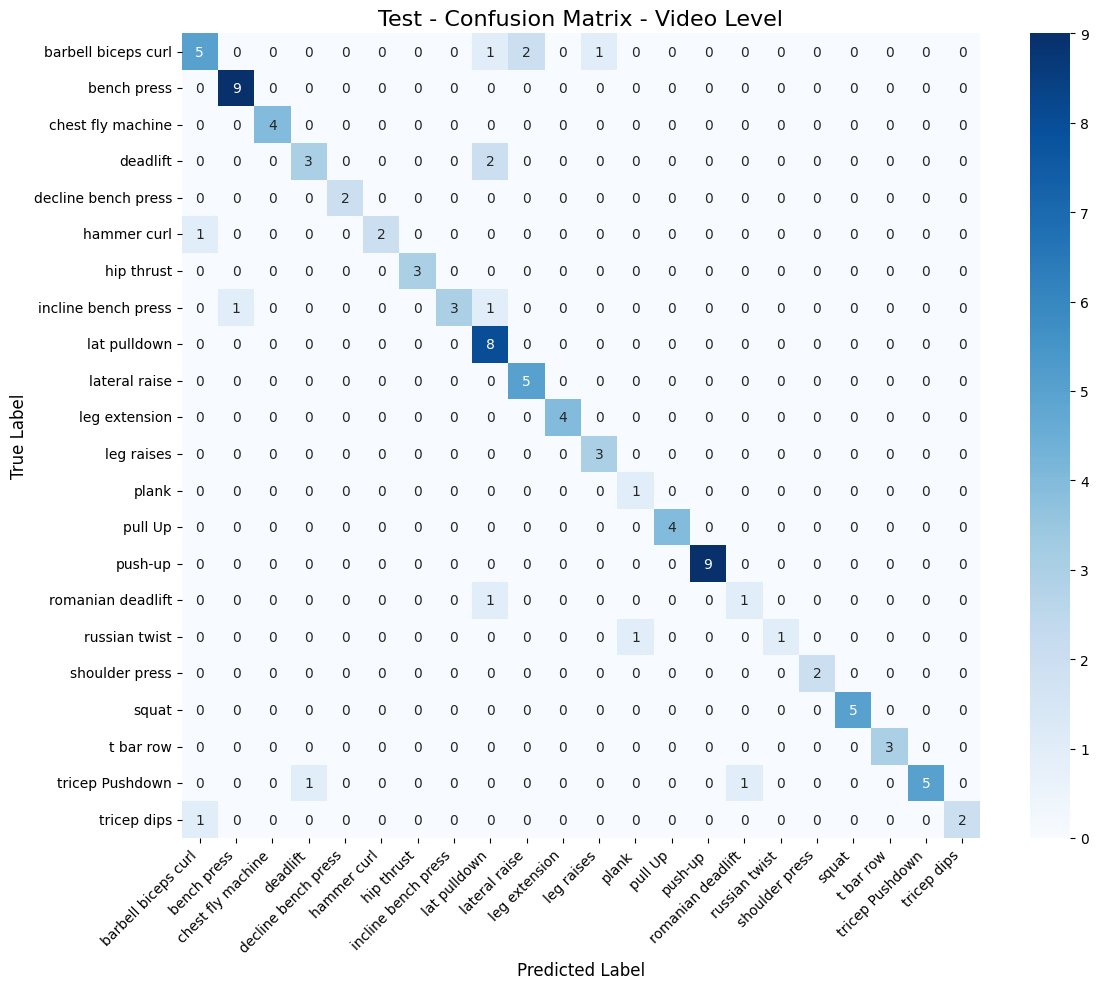

In [42]:
y_true = results_df["true_label"]
y_pred = results_df["predicted_label"]
labels = [inv_map[i] for i in sorted(inv_map)]

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=labels, yticklabels=labels)

plt.title("Test - Confusion Matrix - Video Level", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

plt.savefig(f"{output_path}/Test Confusion Matrix - Video Level.png")
print(f"Plot saved to {output_path}")

plt.show()

In [ ]:
# 9. Save
results_df.to_csv("/content/drive/MyDrive/Beilinson/test_predictions.csv", index=False)